In [1]:
import os
import numpy as np
from scipy.signal import tukey, butter, filtfilt
import matplotlib.pyplot as plt
import shutil

import h5py

from models import UNet, CallBacks
import tensorflow as tf
from tensorflow import keras

In [2]:
""" Setting random seeds """
from models import seed

# TensorFlow
tf.random.set_seed(seed)

# Python
import random as python_random
python_random.seed(seed)

# NumPy (random number generator used for sampling operations)
rng = np.random.default_rng(seed)

# Filtering routines

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=2):
    
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    if low < 0:
        Wn = high
        btype = "lowpass"
    elif high < 0:
        Wn = low
        btype = "highpass"
    else:
        Wn = [low, high]
        btype = "bandpass"

    b, a = butter(order, Wn, btype=btype)
    
    return b, a


def taper_filter(arr, fmin, fmax, samp_DAS):
    b_DAS, a_DAS = butter_bandpass(fmin, fmax, samp_DAS)
    window_time = tukey(arr.shape[1], 0.1)
    arr_wind = arr * window_time
    arr_wind_filt = filtfilt(b_DAS, a_DAS, arr_wind, axis=-1)
    return arr_wind_filt

# Synthetic data generator

The class below overrides the `DataGenerator` class from `models.py` and generates mini-batches of synthetics. Data augmentations include random SNR, moveout (direction), polarity flip, and time reversal.

In [4]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, X, Nt=2048, N_sub=10, batch_size=16, batch_multiplier=10):
        
        # Data matrix
        self.X = X
        # Number of stations
        self.Nx = X.shape[0]
        # Number of time sampling points in data
        self.Nt_all = X.shape[1]
        # Number of time sampling points in a slice
        self.Nt = Nt
        # Number of stations per batch sample
        self.N_sub = N_sub
        # Batch size
        self.batch_size = batch_size
        self.batch_multiplier = batch_multiplier

        self.on_epoch_end()

    def __len__(self):
        """ Number of mini-batches per epoch """
        return int(self.batch_multiplier * self.Nx * self.Nt_all / float(self.batch_size * self.Nt))

    def on_epoch_end(self):
        """ Modify data """
        self.__data_generation()
        pass

    def __getitem__(self, idx):
        """ Select a mini-batch """
        batch_size = self.batch_size
        selection = slice(idx * batch_size, (idx + 1) * batch_size)
        samples = np.expand_dims(self.samples[selection], -1)
        masked_samples = np.expand_dims(self.masked_samples[selection], -1)
        masks = np.expand_dims(self.masks[selection], -1)
        return (samples, masks), masked_samples

    def __data_generation(self):
        """ Generate a total batch """
        
        # Number of mini-batches
        N_batch = self.__len__()
        N_total = N_batch * self.batch_size
        Nt = self.Nt
        N_sub = self.N_sub
        # Buffer for mini-batches
        samples = np.zeros((N_total, N_sub, Nt))
        # Buffer for masks
        masks = np.ones_like(samples)
        
        N_mid = self.Nt_all // 2
        t_starts = rng.integers(low=N_mid-Nt, high=N_mid-Nt//2, size=N_total)
        
        X = self.X
        
        s_min = 1/10_000.
        s_max = 1/200.
        
        gauge = 19.2
        samp = 50.
        
        log_SNR_min = -2
        log_SNR_max = 4
        
        
        # Loop over samples
        for s, t_start in enumerate(t_starts):
            
            sample_ind = rng.integers(low=0, high=self.Nx)            
            t_slice = slice(t_start, t_start + Nt)
            
            # Time reversal
            order = rng.integers(low=0, high=2) * 2 - 1
            # Polarity flip
            sign = rng.integers(low=0, high=2) * 2 - 1
            # Move-out direction
            direction = rng.integers(low=0, high=2) * 2 - 1
            
            slowness = rng.random() * (s_max - s_min) + s_min
            shift = direction * gauge * slowness * samp
            
            sample = sign * X[sample_ind, ::order]
            
            SNR = rng.random() * (log_SNR_max - log_SNR_min) + log_SNR_min
            SNR = 10**(0.5 * SNR)
            amp = 2 * SNR / np.abs(sample).max()
            sample = sample * amp
            
            for i in range(N_sub):                
                samples[s, i] = np.roll(sample, int(i*shift))[t_slice]
            
            # Select one waveform to blank
            blank_ind = rng.integers(low=0, high=self.N_sub)
            masks[s, blank_ind] = 0
            
        gutter = 100
        noise = rng.standard_normal((N_total * N_sub, Nt + 2*gutter))
        noise = taper_filter(noise, fmin=1.0, fmax=10.0, samp_DAS=samp)[:, gutter:-gutter]
        noise = noise.reshape(*samples.shape)
        
        noisy_samples = samples + noise
        for s, sample in enumerate(noisy_samples):
            noisy_samples[s] = sample / sample.std()
            
        self.samples = noisy_samples
        self.masks = masks
        self.masked_samples = noisy_samples * (1 - masks)
        pass

# Model set-up

In [5]:
""" Definitions/parameters """

N_sub = 11
batch_size = 32

model_name = "synthetic_f0=4_logSNR=-2_3_correct-GL-alex"
model_params = {
    "use_bn": False,
    "use_dropout": False,
    "dropout_rate": 0.1,
    "N_blocks": 4,
    "f0": 4,
    "LR": 1e-4,
    "data_shape": (N_sub, 2048, 1),
    "kernel": (3, 5),
    "AA": True,
}

cwd = os.getcwd()
data_dir = os.path.join(cwd, "data")
data_file = os.path.join(data_dir, "SCSN", "waveforms.npy")
data_file = "../DAS-denoiser-MA/data/DAS/SIS-rotated_train_50Hz.npy"

""" Callbacks """

logdir = os.path.join("logs", model_name)
if os.path.isdir(logdir):
    shutil.rmtree(logdir)
    
savefile = "saved-model.h5"
savedir = os.path.join("save", model_name)
if not os.path.isdir(savedir):
    os.makedirs(savedir)

tensorboard_callback = CallBacks.tensorboard(logdir)
checkpoint_callback = CallBacks.checkpoint(os.path.join(savedir, savefile))

# Load data and visualisation

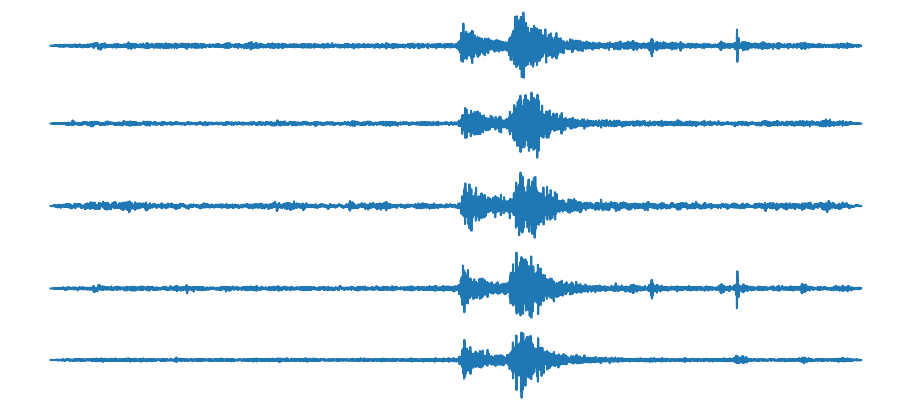

In [6]:
# Load data
data = np.load(data_file)

N_ch, N_t = data.shape

t_slice = slice(N_t//4, 3*N_t//4)
scaled_data = np.zeros_like(data)

# Loop over data and normalise
for i, wv in enumerate(data):
    scaled_data[i] = wv / wv[t_slice].std()

# Draw canvas
fig, axes = plt.subplots(nrows=5, figsize=(9, 4), constrained_layout=True)

# Loop over 5 waveforms
for i in range(len(axes)):
    axes[i].plot(scaled_data[i])
    axes[i].axis("off")

plt.show()

In [7]:
# Split data 80-20 train-test
split = int(0.8 * N_ch)

train_data = scaled_data[:split]
test_data = scaled_data[split:]

noise_std = 2.0

print("Preparing masks")

# Prepare data generator for the train and test set
train_generator = DataGenerator(train_data, N_sub=N_sub, batch_size=batch_size, batch_multiplier=5)
test_generator = DataGenerator(test_data, N_sub=N_sub, batch_size=batch_size, batch_multiplier=5)

print("Done")

Preparing masks
Done


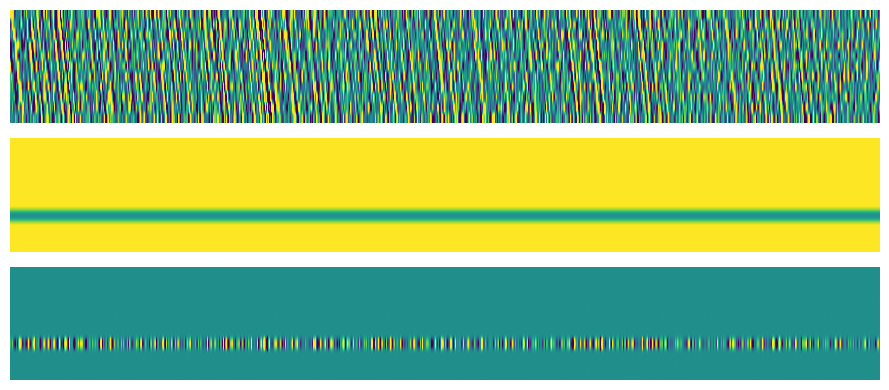

In [8]:
# Get one random mini-batch sample
(samples, masks), masked_samples = test_generator.__getitem__(5)

# Draw canvas
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 4))

# Show sample (without blanking)
axes[0].imshow(samples[0, :, :, 0], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[0].axis("off")

# Show mask
axes[1].imshow(masks[0, :, :, 0], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[1].axis("off")

# Show prediction target
axes[2].imshow(masked_samples[0, :, :, 0], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [9]:
# Construct model
net = UNet()
net.set_params(model_params)
model = net.construct()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 11, 2048, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_1 (InputLayer)           [(None, 11, 2048, 1  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 11, 2048, 1)  0           ['input_2[0][0]',                
                                                                  'input_1[0][0]']            

In [10]:
# Train model on synthetics
model.fit(
    x=train_generator,
    validation_data=test_generator,
    callbacks=[tensorboard_callback, checkpoint_callback],
    verbose=1, epochs=2000,
)

Epoch 1/2000
 47/793 [>.............................] - ETA: 17:13 - loss: 0.0910

KeyboardInterrupt: 